# Get list of papers from venue that cites a dataset

## Import libs

In [81]:
# To request OpenAlex
import requests
import numpy as np
from tqdm import tqdm

#Better print of dict
from pprint import pprint


#To load data
import csv
import pandas as pd

#To filter invalid pdf
from pypdf import PdfReader
from pypdf.errors import PdfReadError

#To handle files
import glob
import os

#To extract images from pdf
import fitz

#To extract tables from pdf
import camelot
import ghostscript

#For visualisation
import matplotlib.pyplot as plt

## Load list of datasets and list of venues
We will search for paper from venue contained in [venues.csv](../../data/venues.csv) referencing one or more of the datasets contained in [datasets.csv](../../data/datasets.csv)

In [4]:
#Dictionnary with dataset's name as key and DOI as value
datasets_doi = {}
ds_reader = csv.DictReader(open('../../data/datasets.csv'))
for ds in ds_reader:
    datasets_doi[ds["name"]] = ds["DOI"]

#Dictionnary with venues name as key and openalex id as value loaded from venues.csv
venue_id = {}
ds_reader = csv.DictReader(open('../../data/venues.csv'))
for ds in ds_reader:
    venue_id[ds["name"]] = ds["openalex_id"]

In [5]:
print("Datasets:")
pprint(datasets_doi)
print("\nVenues:")
pprint(venue_id)

Datasets:
{'ACDC': '10.1109/TMI.2018.2837502',
 'BRATS': '10.1109/tmi.2014.2377694',
 'I2CVB': '10.1016/j.compbiomed.2015.02.009',
 'LA': '10.1016/j.media.2020.101832',
 'M&Ms': '10.1109/tmi.2021.3090082',
 'MSCMRSeg': '10.48550/arxiv.2006.12434',
 'Medical Decathlon': '10.1038/s41467-022-30695-9',
 'PROMISE12': '10.1016/j.media.2013.12.002',
 'Synapse': '10.7303/syn3193805'}

Venues:
{'LNCS': 'S106296714'}


## Try to convert DOI to OpenAlex ID

In [6]:
"""
Convert a DOI to OpenAlex ID used as value in some API field such as "referenced_works"
@param
    - DOI: the doi we want to convert
@return
    The OpenAlex ID if the DOI is in OpenAlex database, None otherwise
"""
def doi_to_OpenAlexId(doi):
    base_url = f"https://api.openalex.org/works/doi:{doi}"
    r = requests.get(base_url)
    if r.status_code == 200:
        r_json = r.json()
        return r_json["id"]
    else:
        return None

#Dictionnary with dataset names as key and openalex id as value. We associate an openalex ID because it's the value in the "referenced_works" field given by the API.
datasets_id = {}

#Convert DOI to OpenAlexID
for ds  in datasets_doi:
    openalex_id = doi_to_OpenAlexId(datasets_doi[ds])
    if not openalex_id:
        print(f"Couldn't convert DOI for {ds} into OpenAlex ID")
    datasets_id[ds]=openalex_id

Couldn't convert DOI for Synapse into OpenAlex ID


In [7]:
pprint(datasets_id)

{'ACDC': 'https://openalex.org/W2804047627',
 'BRATS': 'https://openalex.org/W1641498739',
 'I2CVB': 'https://openalex.org/W2049522781',
 'LA': 'https://openalex.org/W3093394156',
 'M&Ms': 'https://openalex.org/W4226199676',
 'MSCMRSeg': 'https://openalex.org/W4312016581',
 'Medical Decathlon': 'https://openalex.org/W3172681723',
 'PROMISE12': 'https://openalex.org/W2106033751',
 'Synapse': None}


note: Synapse value is None meaning it's note in OpenAlex database, therefore we won't be able to find references to it.

## Get list of papers from each venues citing at least one of the dataset

Query OpenAlex filtering on the dataset and the venue

In [17]:
#Dictionnary containing with dataset as key and a list of papers referencing the dataset as value
paper_referencing = {ds:[] for ds in datasets_id}


for ds in datasets_id:
    for venue in venue_id:
        #The list of paper referencing the dataset is decomposed in multiple pages so we have to iterate with the query parameter "page" to get them all.
        next_page = True
        page_number = 1
        while next_page:
            #Definition of the request
            base_url = "https://api.openalex.org/works"
            query_param = {
                "filter":f"cites:{datasets_id[ds]},locations.source.id:{venue_id[venue]}",
                "page":page_number
            }
            request = requests.get(base_url,params=query_param)

            if request.status_code == 200:
                request_json = request.json()
                
                #For each paper referencing the dataset we get the title (with a little transformation to remove "," and "\n" inside of them), doi and publication year
                for res in request_json["results"]:
                    title = res["title"]
                    title = title.replace(",","")
                    title = title.replace("\n","")
                    
                    fulltext_url = res["open_access"]["oa_url"]
                    #Remove review paper
                    if "review" in title.lower():
                        continue

                    doi = res["doi"]
                    if doi is not None:
                        doi = doi[16:] #Remove the https://doi.org/
                        paper_referencing[ds].append((title,doi,res["publication_year"],res["abstract_inverted_index"],fulltext_url))

                #If the results field is empty that mean we are at the last page so we can continue to the next dataset
                #otherwise we need to go to next page of the current dataset
                if not request_json["results"]:
                    next_page = False
                else:
                    page_number += 1
            else:
                next_page = False
            

In [19]:
for d in paper_referencing:
    print(f"Number of citations for {d}: {len(paper_referencing[d])}")

Number of citations for ACDC: 77
Number of citations for LA: 12
Number of citations for MSCMRSeg: 0
Number of citations for M&Ms: 16
Number of citations for PROMISE12: 24
Number of citations for Medical Decathlon: 2
Number of citations for I2CVB: 9
Number of citations for BRATS: 318
Number of citations for Synapse: 0


# Try to filter out wrong references
This part of the notebook is to obtained a more accurate list of paper to only keep paper that are actually using the dataset and not only referencing the paper for another reason.

To do that we will:
1. Search for the dataset name in the abstract, making the hypothesis that if authors put the name of a dataset inside an abstract they must be using it.
2. Look for the name of the dataset in Table of the fulltext, again if the dataset name is in a Table it should be used (especially if we removed review papers)
3. Classify the figure in the fulltext to detect the organ of the cited dataset. (does not confirm at 100% that the actual dataset is really used and not another one focusing on the same organ)

If none of the above operation validate the citations, the paper is removed from the list. Otherwise, we can keep it.  

##  1. Check abstract for dataset's name

We will now query OpenAlex again for everypaper and search for the dataset name inside the "abstract_inverted_index" field of the API if it's present.

In [20]:
"""
Reconstruct and transform the abstract of a paper using abstract_inverted_index field. We will removed non alpha numeric caracters and lower every word.
"""
def reconstruct_abstract(paper):
    # Maximum size of the abstract, if the paper abstarct is longer it will be truncated
    abstract = np.full(2500,"",dtype=object)
    # The "abstract_inverted_index" field is a dictionnary with word as key and locations of this word in the abstract
    # So we fill the abstarct variable above at the index of the word to reconstruct the abstract
    if paper[3]:
        for w in paper[3]:
            for indices in paper[3][w]:
                if indices < 2500:
                    abstract[indices] = ''.join(filter(str.isalnum, w)).lower()
        # Remove empty location mostly due to a shorter abstract 
        abstract = abstract[abstract != ""]
        #Convert array to string
    str_abstract = ' '.join(abstract)
    return str_abstract

In [71]:
paper_using_abstract = {dataset:[] for dataset in paper_referencing}
for dataset in paper_referencing:
    for paper in paper_referencing[dataset]:
        abstract = reconstruct_abstract(paper)
        if dataset.lower() in abstract:
            paper_using_abstract[dataset].append(paper[1])

In [72]:
for d in paper_using_abstract:
    paper_using_abstract[d] = set(paper_using_abstract[d])
    print(f"Number of citations for {d}: {len(paper_using_abstract[d])}")

Number of citations for ACDC: 13
Number of citations for LA: 12
Number of citations for MSCMRSeg: 0
Number of citations for M&Ms: 0
Number of citations for PROMISE12: 3
Number of citations for Medical Decathlon: 0
Number of citations for I2CVB: 0
Number of citations for BRATS: 167
Number of citations for Synapse: 0


### Download paper's fulltexts

In [23]:
downloaded_doi = []
title_to_doi = {}

In [24]:
for dataset in paper_referencing:
    print(dataset)
    for paper in tqdm(paper_referencing[dataset]):
        title = paper[0].replace('/','')
        doi = paper[1]
        fulltext_url = paper[4]
        if title not in title_to_doi:
            title_to_doi[title]=doi
        if not fulltext_url:
            continue
        if not paper in paper_using_abstract[dataset]:
            #Check that paper hasn't been downloaded before (for another dataset), otherwise try to download it
            file_path = f"../../results/papers_fulltext/downloaded_pdf/{title}.pdf"
            if doi not in downloaded_doi:
                try:
                    r_fulltext = requests.get(fulltext_url,allow_redirects=True,timeout=10)
                    pdf_content = r_fulltext.content
                    if r_fulltext.status_code == 200:
                        open(file_path,"wb").write(r_fulltext.content)
                        downloaded_doi.append(doi)
                    else:
                        continue
                except requests.exceptions.RequestException as ce:
                    continue
            try:
                #Try to read the pdf (Raise an error if the file is an invalid pdf)
                PdfReader(file_path,strict=True)
            except PdfReadError:
                #If a PdfReadError is raised, the pdf is invalid and therefore removed from downloaded list
                downloaded_doi.remove(doi)
                continue


ACDC


100%|██████████| 77/77 [02:36<00:00,  2.03s/it]


LA


100%|██████████| 12/12 [00:04<00:00,  2.99it/s]


MSCMRSeg


0it [00:00, ?it/s]


M&Ms


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


PROMISE12


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Medical Decathlon


100%|██████████| 2/2 [00:00<00:00, 21564.54it/s]


I2CVB


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


BRATS


100%|██████████| 318/318 [05:01<00:00,  1.06it/s]


Synapse


0it [00:00, ?it/s]


In [25]:
print(f"Number of downloaded fulltext: {len(downloaded_doi)}")

Number of downloaded fulltext: 190


At this point we have access to the pdf of the article. We first want to check whether the name of the dataset appears in the tables. The hypothesis is that if a dataset name appears in a table, it must be a table of results. And since we have removed the review papers from the list, this should indicate that the dataset is really used.

## 2. Check tables in fulltext for dataset's name

In [105]:
pdf_path = glob.glob("../../results/papers_fulltext/downloaded_pdf/*.pdf")

In [44]:
paper_using_tables = {dataset:[] for dataset in paper_referencing}
for pdf in tqdm(pdf_path):
    try:
        tables = camelot.read_pdf(pdf,"all",flavor="stream",suppress_stdout=True)
        title= pdf.split("/")[-1].removesuffix(".pdf")
        for t in tables:
            t_str = t.df.to_string()
            for dataset in paper_using_tables:
                if dataset.lower() in t_str.lower():
                    paper_using_tables[dataset].append(title_to_doi[title])
    except:
        continue           

 51%|█████▏    | 98/191 [08:18<03:57,  2.55s/it]  invalid pdf header: b'<!DOC'
EOF marker not found
 72%|███████▏  | 138/191 [09:58<02:13,  2.52s/it]Object 259 0 not defined.
Object 307 0 not defined.
Object 373 0 not defined.
Object 446 0 not defined.
Object 584 0 not defined.
100%|██████████| 191/191 [13:13<00:00,  4.15s/it]


In [48]:
for d in paper_using_tables:
    paper_using_tables[d] = set(paper_using_tables[d])
    print(f"Number of citations for {d}: {len(paper_using_tables[d])}")

Number of citations for ACDC: 33
Number of citations for LA: 185
Number of citations for MSCMRSeg: 0
Number of citations for M&Ms: 8
Number of citations for PROMISE12: 12
Number of citations for Medical Decathlon: 0
Number of citations for I2CVB: 2
Number of citations for BRATS: 120
Number of citations for Synapse: 5


## 3. Check for dataset's organ in figures

In [106]:
#path of folder where images will be stored
images_path = "../../results/papers_fulltext/images"
#Create this folder if it does not exist
if not os.path.exists(images_path):
    os.makedirs(images_path)

paper_using_figures = {dataset:[] for dataset in paper_referencing}
#For each pdf file
for file in pdf_path:
    #Open the file
    pdf_file = fitz.open(file)

    #Get the number of pages in PDF file
    page_nums = len(pdf_file)

    #Create empty list to store images information
    images_list = []

    #Extract all images information from each page
    for page_num in range(page_nums):
        page_content = pdf_file[page_num]
        images_list.extend(page_content.get_images())

    #If there is at least one image in the pdf
    if len(images_list)!=0:
        #Create a subfolder for the article, this way we easily know from which paper the images is coming from
        if not os.path.exists(os.path.join(images_path, os.path.basename(file.replace(".pdf","")))):
            os.makedirs(os.path.join(images_path, os.path.basename(file.replace(".pdf",""))))

        #Save all the extracted images
        for i, img in enumerate(images_list, start=1):
            #Extract the image object number
            xref = img[0]
            #Extract image
            base_image = pdf_file.extract_image(xref)
            #Store image bytes
            image_bytes = base_image['image']
            #Store image extension
            image_ext = base_image['ext']
            #Generate image file name
            image_name = str(i) + '.' + image_ext
            #Save image
            with open(os.path.join(images_path, os.path.basename(file.replace(".pdf","")),image_name) , 'wb') as image_file:
                image_file.write(image_bytes)
                image_file.close()
             
            #TODO APPLY MODEL

## 4. Combine all outcome

In [74]:
confirmation_method = [paper_using_abstract,paper_using_tables,paper_using_figures]
paper_confirmed = {dataset:[] for dataset in paper_referencing}
for outcome in confirmation_method:
    for dataset in outcome:
        for paper in outcome[dataset]:
            paper_confirmed[dataset].append(paper)

## Plot and save results 

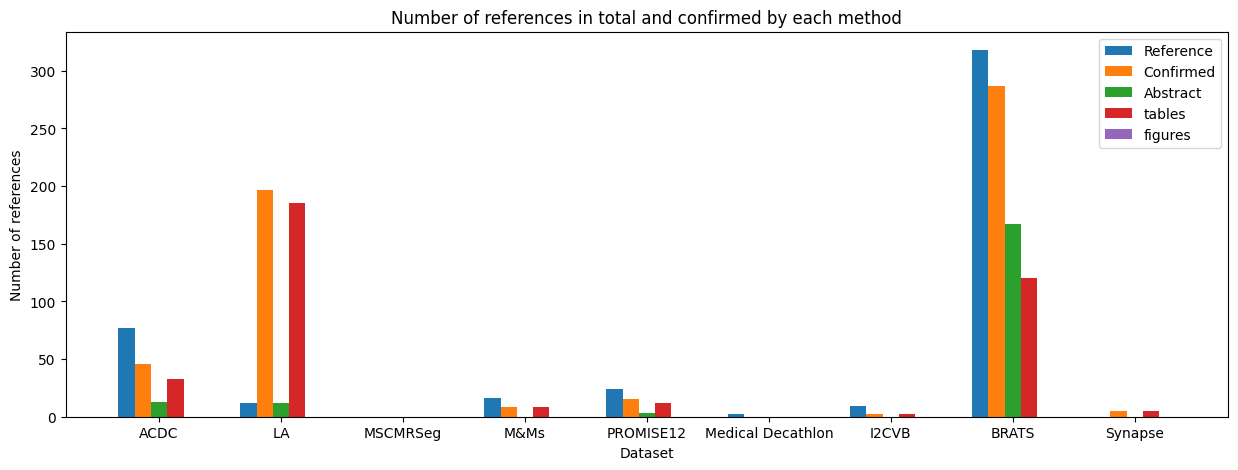

In [113]:
X = list(paper_confirmed.keys())
nb_ref = [len(paper_referencing[x]) for x in X]
nb_confirmed = [len(paper_confirmed[x]) for x in X]
nb_abstract = [len(paper_using_abstract[x]) for x in X]
nb_tables = [len(paper_using_tables[x]) for x in X]
nb_figures = [len(paper_using_figures[x]) for x in X]

X_axis = np.arange(0,len(X)*3,3)

plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.8, nb_ref, 0.4, label = 'Reference')
plt.bar(X_axis - 0.4, nb_confirmed, 0.4, label = 'Confirmed')
plt.bar(X_axis, nb_abstract, 0.4, label = 'Abstract')
plt.bar(X_axis + 0.4, nb_tables, 0.4, label = 'tables')
plt.bar(X_axis + 0.8, nb_figures, 0.4, label = 'figures')
  
plt.xticks(X_axis, X)
plt.xlabel("Dataset")
plt.ylabel("Number of references")
plt.title("Number of references in total and confirmed by each method")
plt.legend()
plt.show()

# for d in paper_confirmed:
#     print(f"Number of confirmed citations with abstract for {d}: {len(paper_using_abstract[d])}")
#     print(f"Number of confirmed citations with tables for {d}: {len(paper_using_tables[d])}")
#     print(f"Number of confirmed citations with figures for {d}: {len(paper_using_figures[d])}")

#     print(f"Number of confirmed citations for {d}: {len(paper_confirmed[d])}\n")

# Example code for download 

# Check fulltext of paper for either figures or tables

## Extract images from valid pdf

In [4]:
#get every valid pdf path
valid_pdf_path = glob.glob("../../results/papers_fulltext/valid_pdf/*.pdf")

#path of folder where images will be stored
images_path = "../../results/papers_fulltext/images"
#Create this folder if it does not exist
if not os.path.exists(images_path):
    os.makedirs(images_path)

#For each pdf file
for file in valid_pdf_path:
    #Open the file
    pdf_file = fitz.open(file)

    #Get the number of pages in PDF file
    page_nums = len(pdf_file)

    #Create empty list to store images information
    images_list = []

    #Extract all images information from each page
    for page_num in range(page_nums):
        page_content = pdf_file[page_num]
        images_list.extend(page_content.get_images())

    #If there is at least one image in the pdf
    if len(images_list)!=0:
        #Create a subfolder for the article, this way we easily know from which paper the images is coming from
        if not os.path.exists(os.path.join(images_path, os.path.basename(file.replace(".pdf","")))):
            os.makedirs(os.path.join(images_path, os.path.basename(file.replace(".pdf",""))))

        #Save all the extracted images
        for i, img in enumerate(images_list, start=1):
            #Extract the image object number
            xref = img[0]
            #Extract image
            base_image = pdf_file.extract_image(xref)
            #Store image bytes
            image_bytes = base_image['image']
            #Store image extension
            image_ext = base_image['ext']
            #Generate image file name
            image_name = str(i) + '.' + image_ext
            #Save image
            with open(os.path.join(images_path, os.path.basename(file.replace(".pdf","")),image_name) , 'wb') as image_file:
                image_file.write(image_bytes)
                image_file.close()

